In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# One patch

### Load a file and label the stream stars

In [ ]:
df = load_file()

In [ ]:
make_plots(df)

In [ ]:
plt.figure(dpi=150)
plt.scatter(df[df.stream]['α_wrapped']-360, df[df.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars");
plt.xlim(-241,-135);
plt.ylim(-10,65);

# Make dataframe of all patches

In [2]:
patch_list = [
 # b = 33.7 
 '../gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 '../gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 '../gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 '../gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 '../gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 '../gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 '../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 '../gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 '../gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 '../gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 '../gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 '../gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 '../gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 '../gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 '../gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 '../gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 '../gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 '../gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 '../gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [3]:
# ### Slow -- make the dataframes (better in a separate screen, tbh) 
# for file in tqdm(patch_list):
#     df = load_file(file)
#     df["patch_id"] = patch_list.index(file)
#     df.to_hdf(file[:-4]+".h5", "df")

In [4]:
### Fast -- load the dataframes & concatenate 
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
    dfs.append(df)
df_all = pd.concat(dfs)

100%|██████████| 21/21 [00:05<00:00,  3.93it/s]


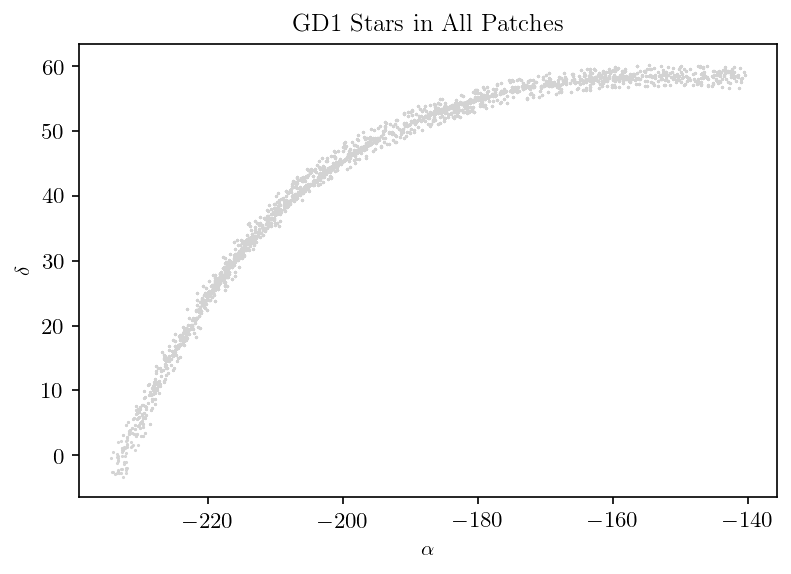

In [5]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α_wrapped'] - 360, df_all[df_all.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

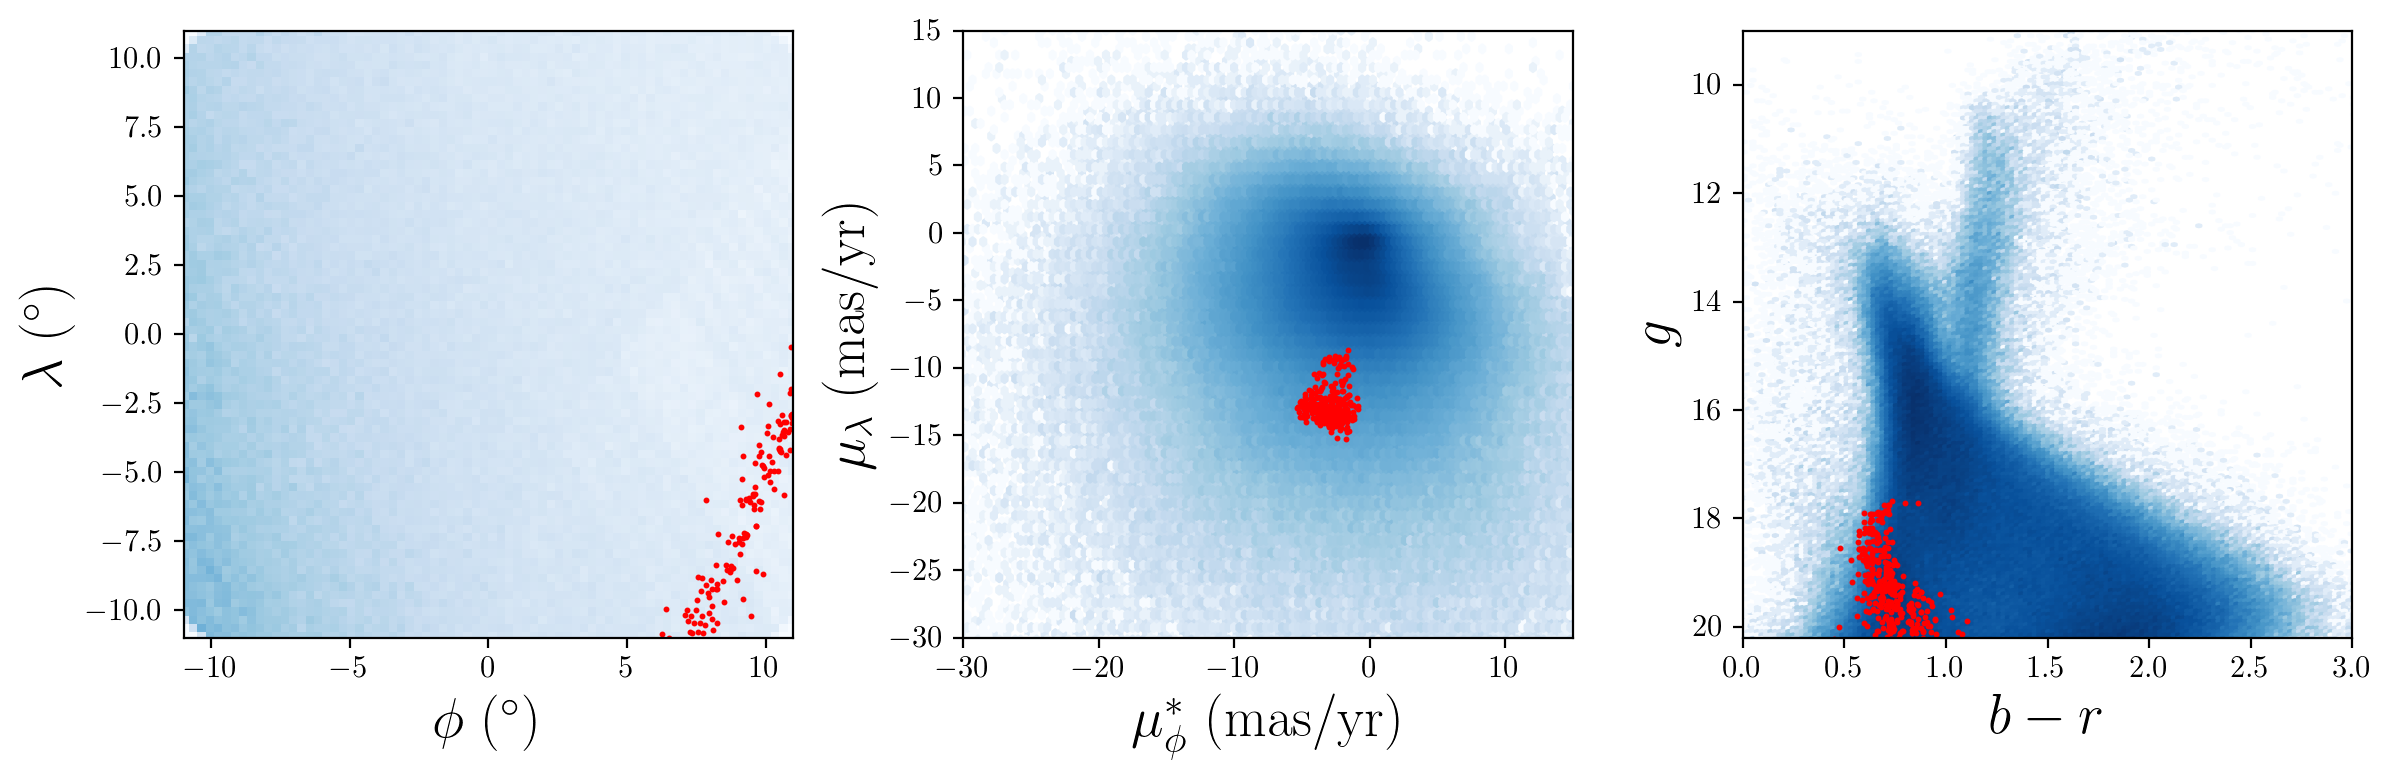

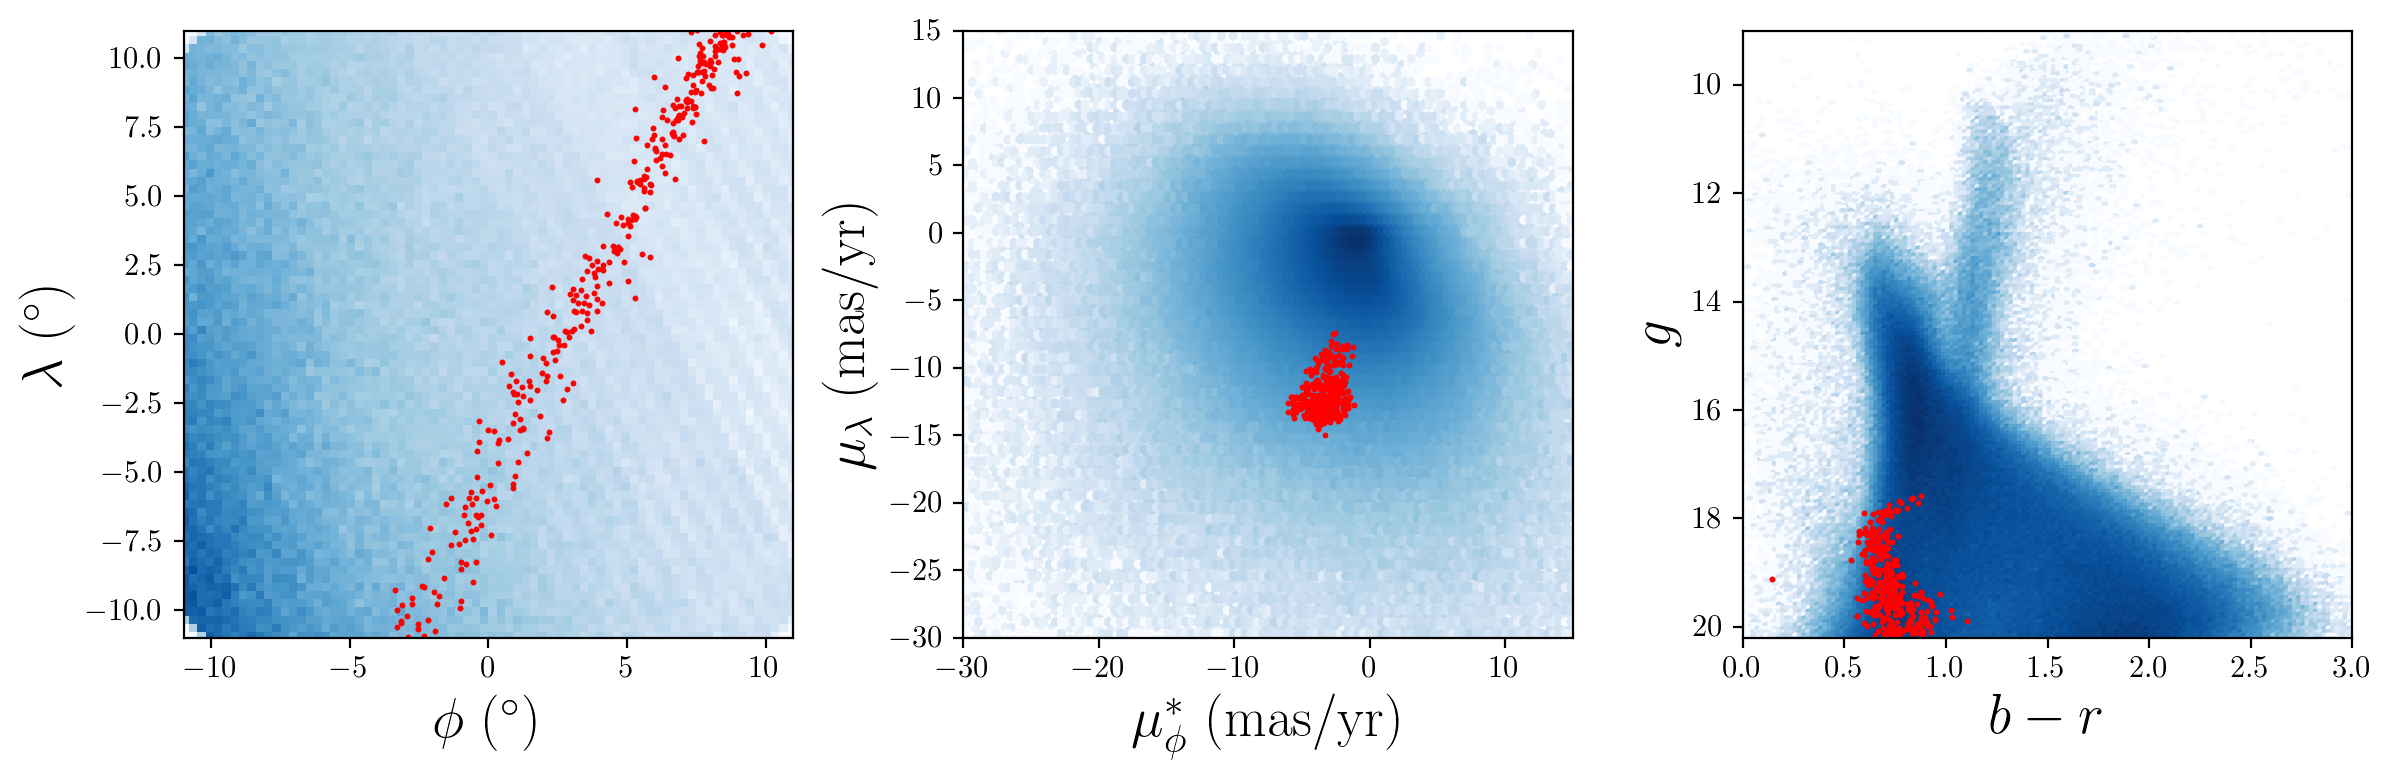

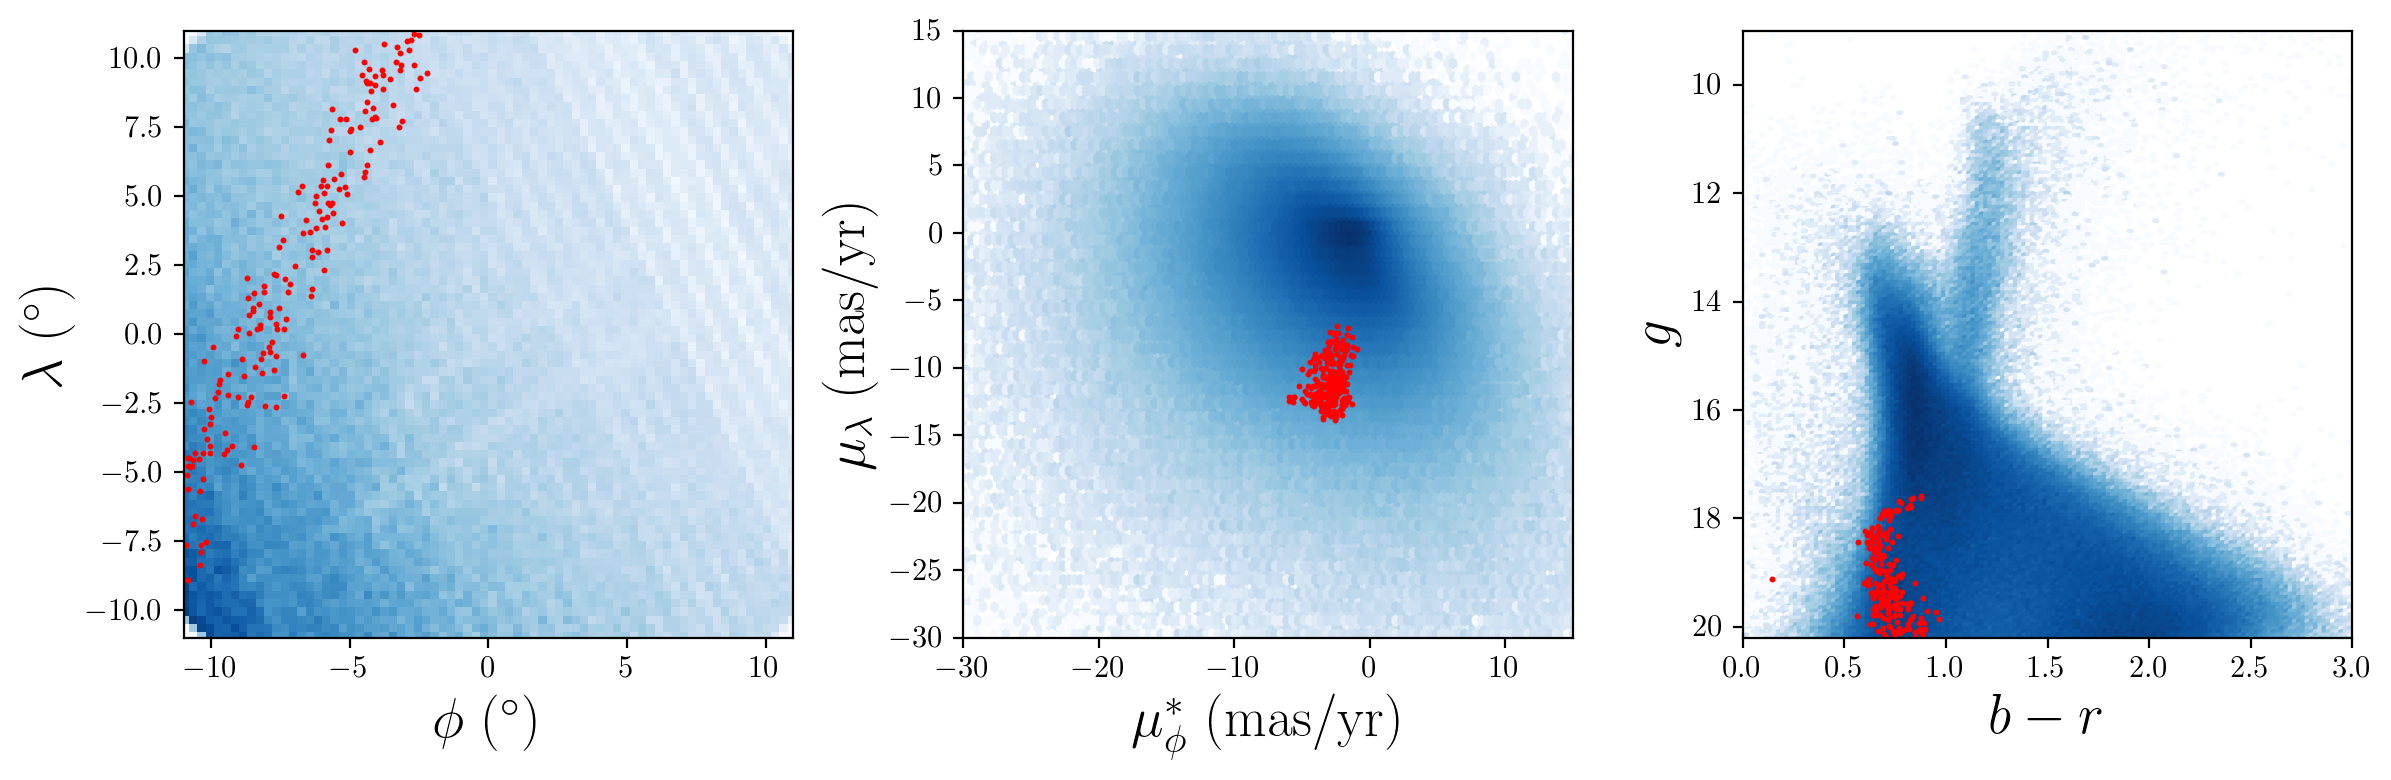

In [6]:
for patch_id in [0,1,2]: #df_all.patch_id.unique(): 
    df = df_all[df_all.patch_id == patch_id]
    
    fig = plt.figure(figsize=(12,4), dpi=200, tight_layout=True)
    ax = fig.add_subplot(131)
    ax.hist2d(df['ϕ'], df['λ'], bins=100, cmap="Blues");
    ax.scatter(df[df.stream]['ϕ'], df[df.stream]['λ'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$\phi~(^\circ)$',fontsize=20)
    ax.set_ylabel(r'$\lambda~(^\circ)$',fontsize=20)
    ax.set_xlim(-11,11);
    ax.set_ylim(-11,11);

    ax = fig.add_subplot(132)
    ax.hexbin(df['μ_ϕcosλ'], df['μ_λ'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['μ_ϕcosλ'], df[df.stream]['μ_λ'], marker='.', s=5, color='red')
    ax.set_xlim(-30,15)
    ax.set_ylim(-30,15)
    ax.set_xlabel(r'$\mu_\phi^*$ (mas/yr)',fontsize=20)
    ax.set_ylabel(r'$\mu_\lambda$ (mas/yr)',fontsize=20)

    ax = fig.add_subplot(133)
    ax.hexbin(df['b-r'], df['g'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['b-r'], df[df.stream]['g'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$b-r$',fontsize=20)
    ax.set_ylabel(r'$g$',fontsize=20)
    ax.set_xlim(0,3)
    ax.set_ylim(9,20.2)
    ax.invert_yaxis() 

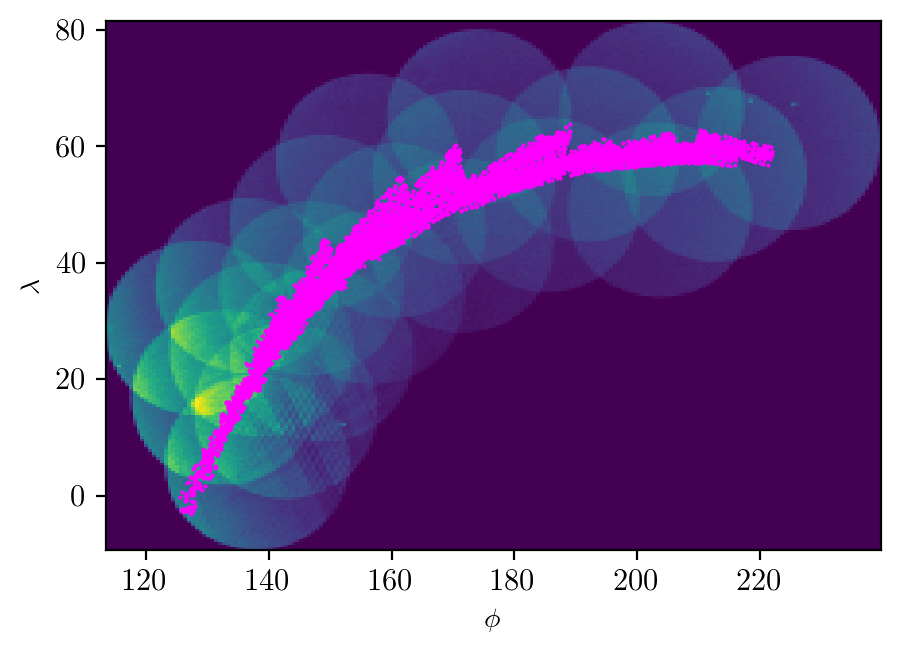

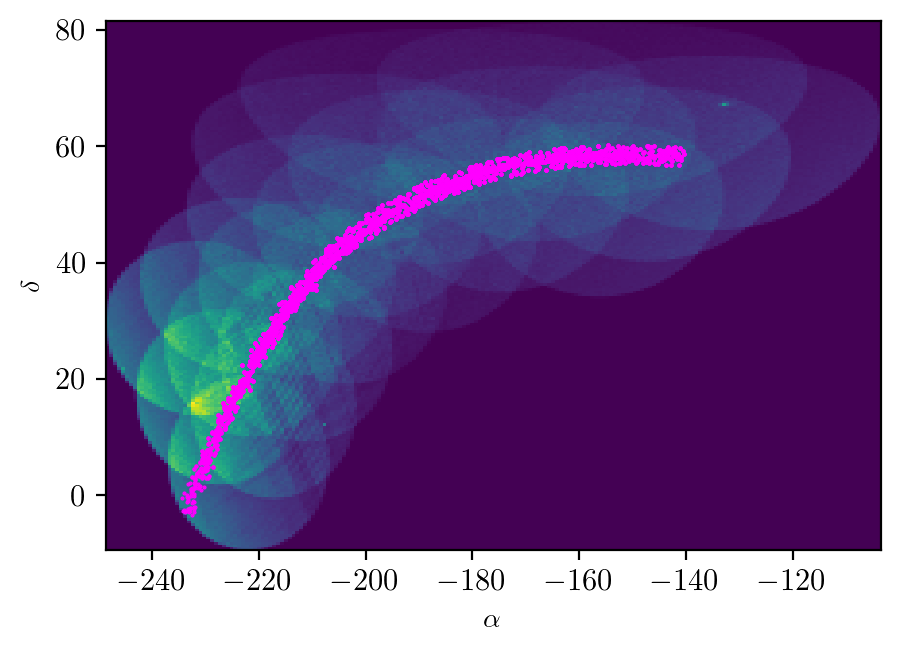

In [18]:
### α0 and δ0 offsets of each patch 

offsets = {
    "patch_0" : (128.4, 28.8),
    "patch_1" : (132.6, 16.9),
    "patch_2" : (138.1, 5.7),
    "patch_3" : (136.5, 36.1),
    "patch_4" : (138.8, 25.1),
    "patch_5" : (142.7, 14.5),
    "patch_6" : (224.7, 60.6),
    "patch_7" : (202.4, 66.5),
    "patch_8" : (174.3, 65.1),
    "patch_9" : (156.2, 57.5),
    "patch_10" : (148.6, 47.0),
    "patch_11" : (146.9, 35.6),
    "patch_12" : (148.6, 24.2),
    "patch_13" : (212.7, 55.2),
    "patch_14" : (192.0, 58.7),
    "patch_15" : (171.8, 54.7),
    "patch_16" : (160.5, 45.5),
    "patch_17" : (156.9, 34.1),
    "patch_18" : (203.7, 49.1),
    "patch_19" : (185.4, 50.0),
    "patch_20" : (171.4, 43.0),
          }

patches = []
for patch_id in range(21): 
    patch = df_all[df_all.patch_id == patch_id]
    patch['ϕ_absolute'] = patch['ϕ'] + offsets['patch_'+str(patch_id)][0]
    patch['λ_absolute'] = patch['λ'] + offsets['patch_'+str(patch_id)][1]
    patches.append(patch)
df = pd.concat(patches)

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['ϕ_absolute'], df['λ_absolute'], bins=200);
plt.scatter(df[df.stream]['ϕ_absolute'], df[df.stream]['λ_absolute'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\phi$');
plt.ylabel(r'$\lambda$');

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['α_wrapped'] - 360, df['δ'], bins=200);
plt.scatter(df[df.stream]['α_wrapped'] - 360, df[df.stream]['δ'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\alpha$');
plt.ylabel(r'$\delta$');

# Remake Via Machinae plot from test dataframes saved during the training

33.333333333333336
51.0
86.0
91.0
92.0
0.0
skipping ../trained_models/new_sr1_sb3/patches/patch13/df_test.h5
70.0
68.0
80.0
90.0
0.0
skipping ../trained_models/new_sr1_sb3/patches/patch18/df_test.h5
58.0
0.0
skipping ../trained_models/new_sr1_sb3/patches/patch2/df_test.h5
67.0
93.0
88.0
57.0
0.0
skipping ../trained_models/new_sr1_sb3/patches/patch6/df_test.h5
61.0
26.666666666666668
14.705882352941176

1,958 true GD-1 stars pass fiducial cuts.
876 stars identified by CWoLa, of which 557 belong to GD-1.

Purity = 64% in top CWoLa-identified stars
Completeness = 28% vs. all of GD-1


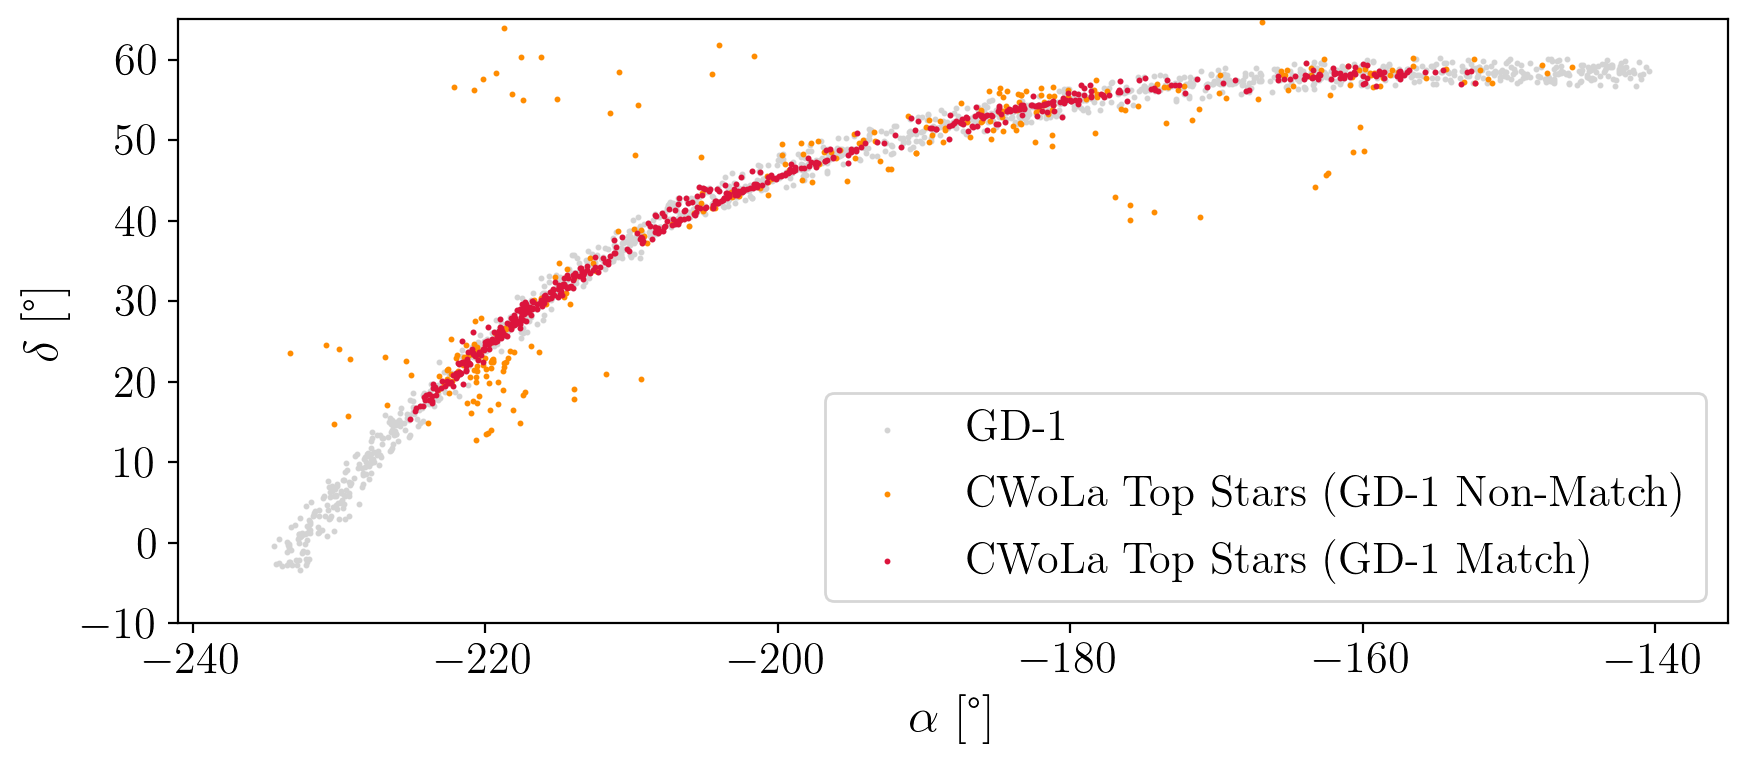

In [180]:
all_gd1_stars = []
cwola_stars = []

# files = sorted(glob("../trained_models/aps_50_patches_nfolds1/patches/patch*/df_test.h5"))
# files = sorted(glob("../trained_models/vm_sr1_sb3_50patches/patches/patch*/df_test.h5"))
files = sorted(glob("../trained_models/new_sr1_sb3/patches/patch*/df_test.h5"))

for file in files: # use all files to create stream stars
    test = pd.read_hdf(file)
#     test = fiducial_cuts(test)
    all_gd1_stars.append(test[test.stream])    

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    print(purity)
    if purity < 1:
        print("skipping "+str(file))
        continue
    else:
        cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

all_gd1_stars.reset_index(inplace=True)
all_gd1_stars.drop_duplicates(subset = 'index')
all_gd1_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

cwola_stars.reset_index(inplace=True)
cwola_stars.drop_duplicates(subset = 'index')
cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

all_gd1_stars['α'] = all_gd1_stars['α']-360
cwola_stars['α'] = cwola_stars['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α_wrapped - 360, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α_wrapped - 360, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

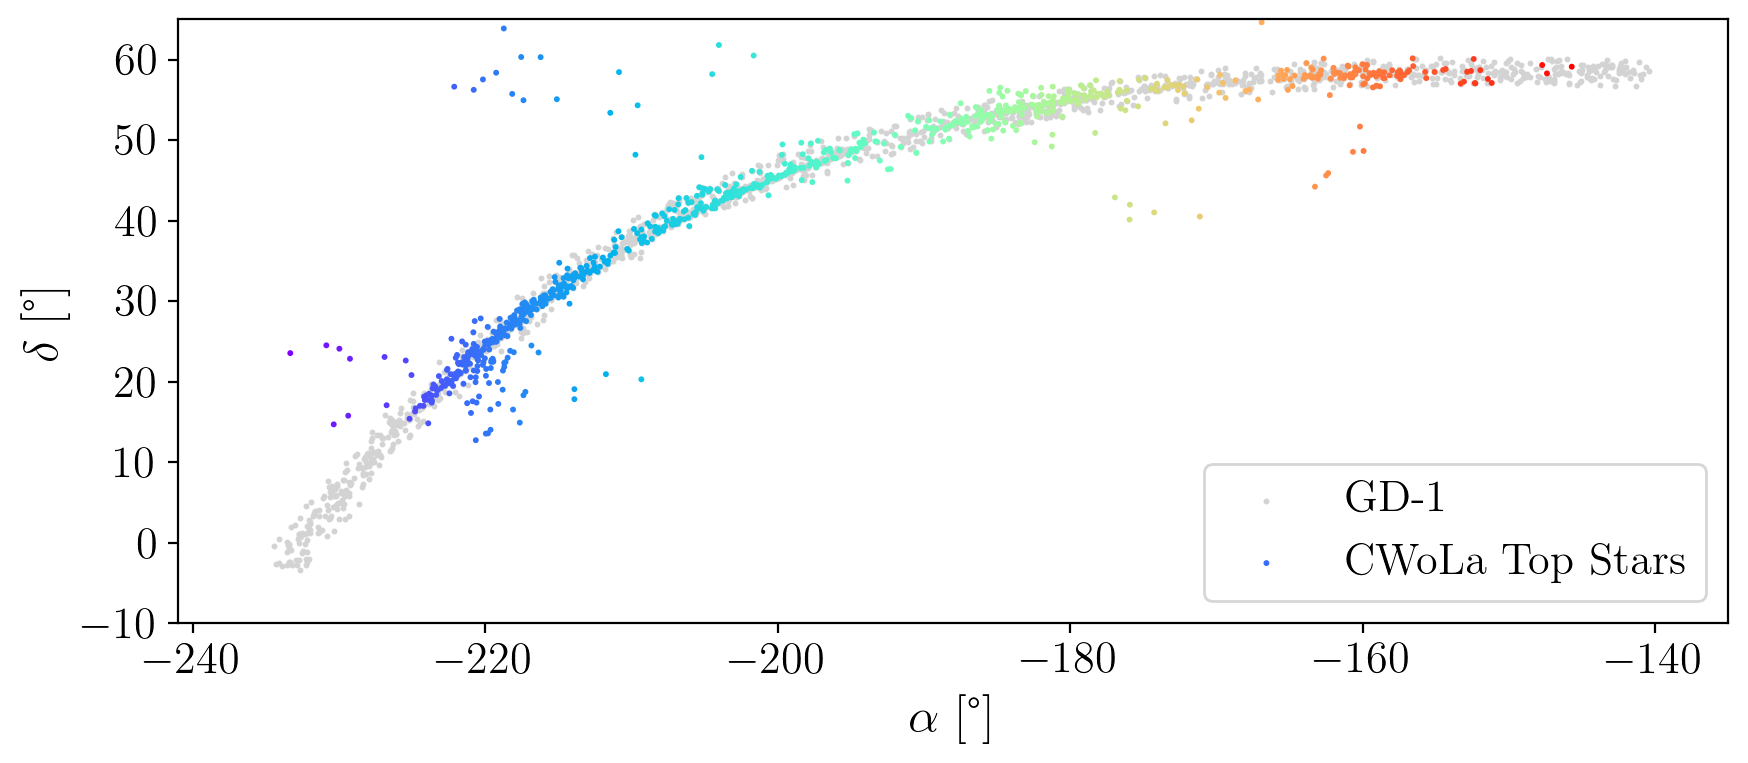

In [181]:
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars.α_wrapped - 360, cwola_stars.δ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
plt.xlim(-241,-135);
plt.ylim(-10,65);

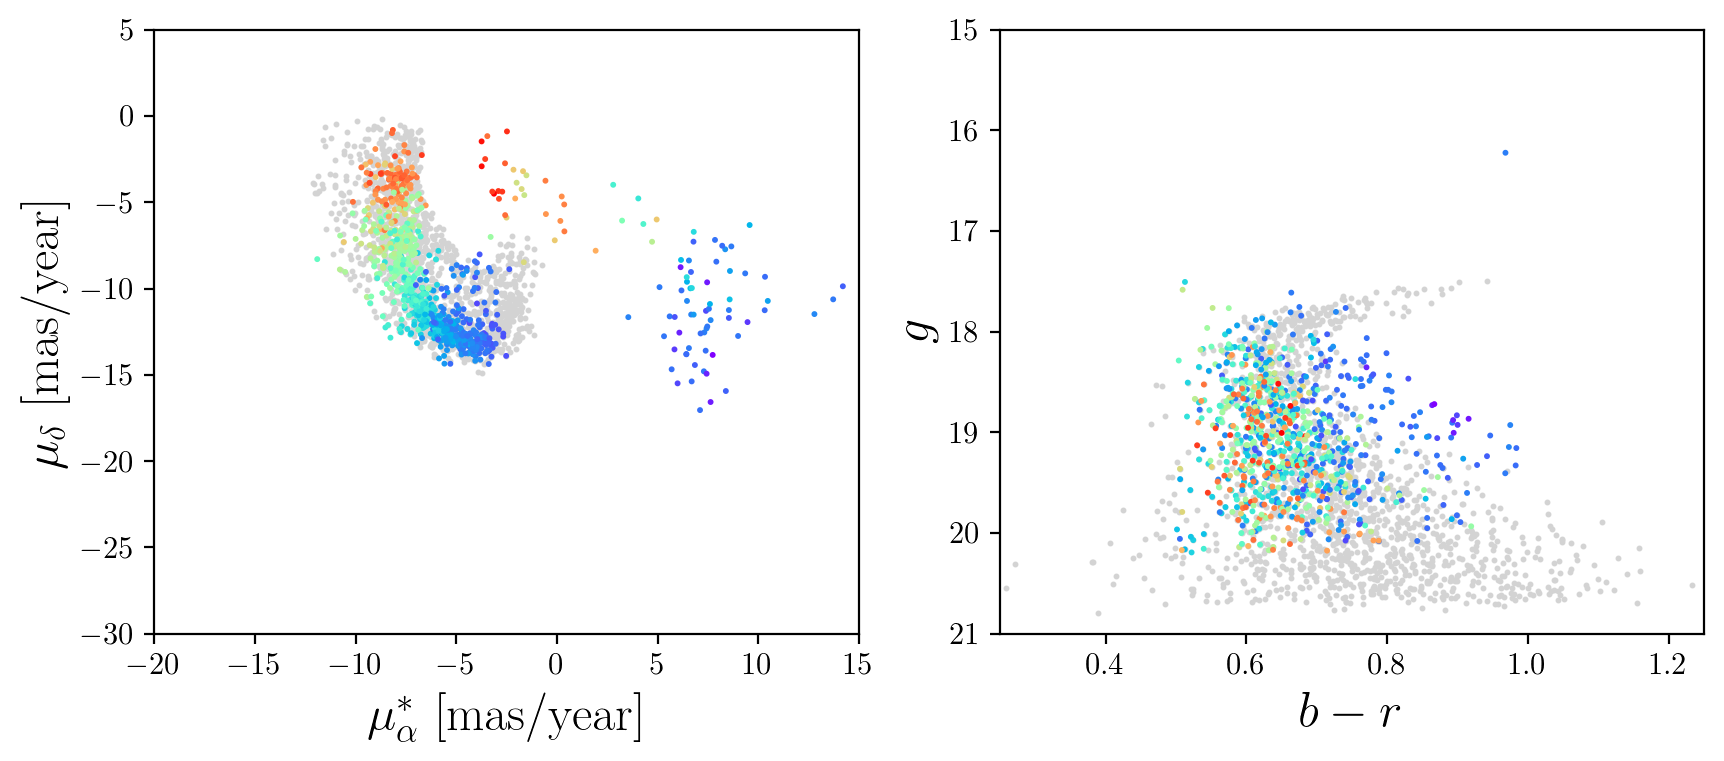

In [182]:
markersize = 5
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(10,4))

ax = axs[0]
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars.μ_α, cwola_stars.μ_δ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$\mu_\alpha^*$ [mas/year]", fontsize=18);
ax.set_ylabel(r"$\mu_\delta$ [mas/year]", fontsize=18);
ax.set_xlim(-20,15);
ax.set_ylim(-30,5);

ax = axs[1]
ax.scatter(all_gd1_stars['b-r'], all_gd1_stars.g, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars['b-r'], cwola_stars.g, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$b-r$", fontsize=18);
ax.set_ylabel(r"$g$", fontsize=18);
ax.set_xlim(0.25,1.25);
ax.set_ylim(15,21);
ax.invert_yaxis()

# Rotate coordinates to stream-aligned $\phi_1$ and $\phi_2$

In [183]:
import astropy.units as u
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

In [184]:
gd1_frame = GD1Koposov10()

### All GD-1 stars
coord_icrs = SkyCoord(ra=(all_gd1_stars['α_wrapped'] - 360)*u.degree, dec=all_gd1_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
all_gd1_stars['ϕ1'] = coord_gd1.phi1.degree
all_gd1_stars['ϕ2'] = coord_gd1.phi2.degree

### CWoLa stars
coord_icrs = SkyCoord(ra=(cwola_stars['α_wrapped'] - 360)*u.degree, dec=cwola_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
cwola_stars['ϕ1'] = coord_gd1.phi1.degree
cwola_stars['ϕ2'] = coord_gd1.phi2.degree

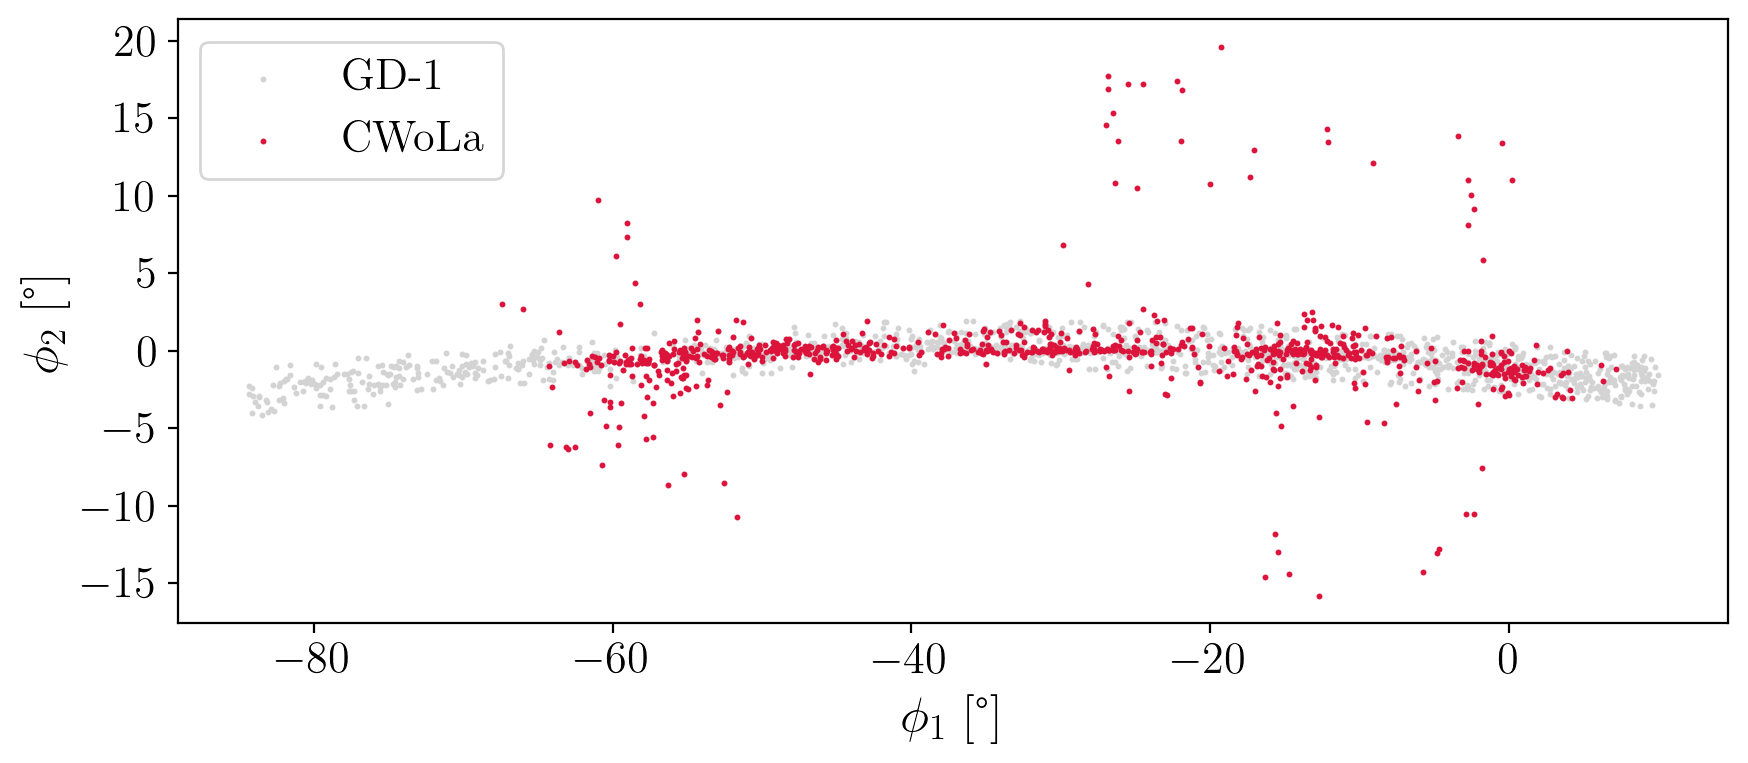

In [185]:
markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars['ϕ1'], all_gd1_stars['ϕ2'], marker='.', s=markersize, color="lightgray", label="GD-1")
plt.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
# plt.xlim(-100,20);
# plt.ylim(-5,1);

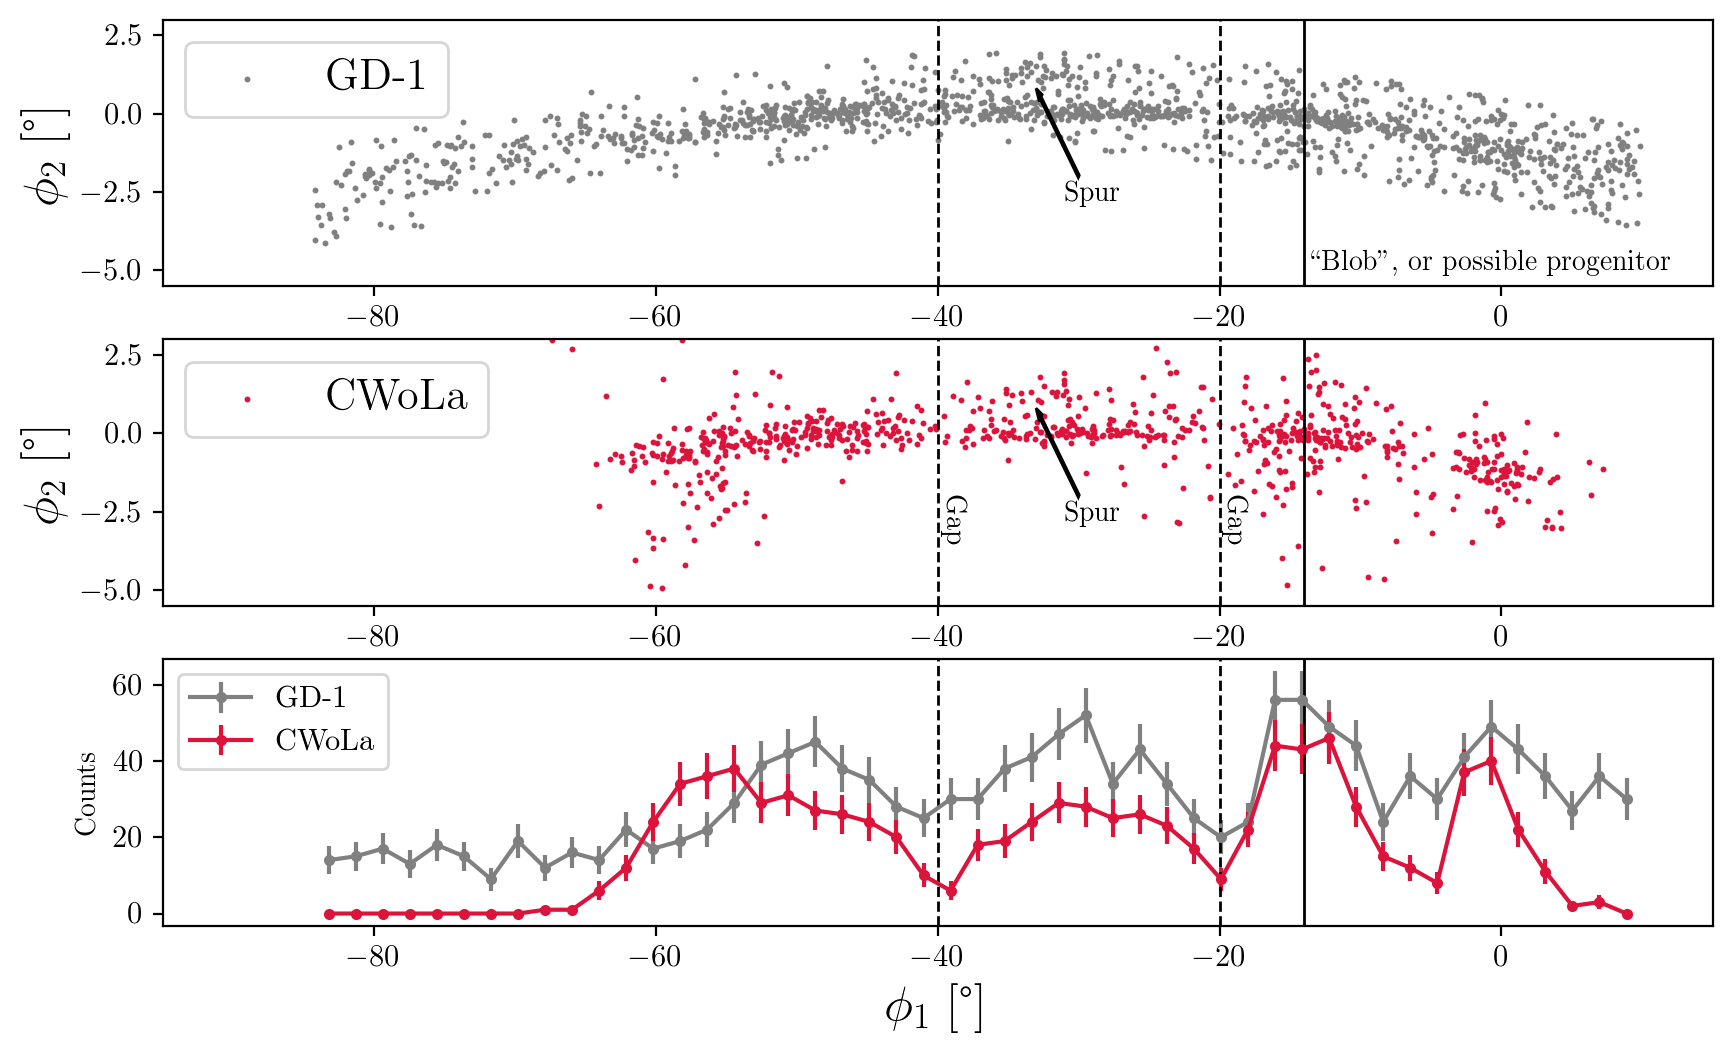

In [191]:
markersize = 5
fig, axs = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(10,6))

# gd1_stars = all_gd1_stars
gd1_stars = all_gd1_stars[(all_gd1_stars.g < 20.2) & (0.5 < all_gd1_stars['b-r']) & (all_gd1_stars['b-r'] < 1)]

ax = axs[0]
ax.scatter(gd1_stars['ϕ1'], gd1_stars['ϕ2'], marker='.', s=markersize, color="gray", label="GD-1")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.axvline(-40,c='k',linestyle='dashed',lw=1)
ax.axvline(-20,c='k',linestyle='dashed',lw=1)
ax.axvline(-14,c='k',lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-14+0.5,-5,'``Blob", or possible progenitor',rotation=0)

ax = axs[1]
ax.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-40+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.axvline(-14,c='k',lw=1)
ax.text(-20+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)

ax = axs[2]
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_xlim(-95,15);

bins = np.linspace(np.min(gd1_stars['ϕ1']),np.max(gd1_stars['ϕ1']),50)
counts_gd1, _   = np.histogram(gd1_stars['ϕ1'], bins=bins) 
counts_cwola, _ = np.histogram(cwola_stars['ϕ1'], bins=bins) 
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_gd1, yerr=np.sqrt(counts_gd1),  marker='.',c='gray', label='GD-1')
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_cwola, yerr=np.sqrt(counts_cwola), marker='.', c='crimson', label='CWoLa')
ax.legend(loc='upper left');
ax.axvline(-14,c='k',lw=1)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.set_ylabel('Counts');
# ax.set_ylim(0,80);
plt.savefig("phi1_phi2_brg_cuts.pdf")

In [192]:
all_gd1_stars.shape

(1958, 18)

## Add promising stars

In [ ]:
labeled = cwola_stars[cwola_stars.stream]
unlabeled = cwola_stars[cwola_stars.stream == False]

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

Identify promising unlabeled stars...

In [ ]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
unlabeled['5d_distance'] = distances

plt.figure(dpi=300)
plt.hist(unlabeled["5d_distance"], bins=60)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance");
# plt.savefig("../plots/5d_distance.png")

In [ ]:
# promising = unlabeled[(unlabeled['5d_distance'] < 1)] # restrict by a specific distance
promising = unlabeled[(unlabeled['5d_distance'] < unlabeled['5d_distance'].quantile(0.1))] # restrict to the top x%

In [ ]:
len(promising)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="promising (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

In [ ]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(promising.α, promising.δ, marker='.', s=10, 
            color="dodgerblue", label="CWoLa (Promising Candidates)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.png");